# Initial test: original program and pre-trained net 
Original Keras implementation obtained from: [here](https://github.com/xslittlegrass/CarND-Vehicle-Detection)

In this notebook:

1. Library imports
2. Tiny-Yolo model definition
3. Load pre-trained wights 
4. Test results with one image
5. Test results with several images
6. Test with video (generate video annotated output)

In [1]:
!python -c "import keras; print keras.__version__"

Using TensorFlow backend.
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcublas.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcudnn.so.5 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcufft.so.8.0 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcuda.so.1 locally
I tensorflow/stream_executor/dso_loader.cc:135] successfully opened CUDA library libcurand.so.8.0 locally
2.0.5


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box
import time

keras.backend.set_image_dim_ordering('th')

model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
# model.add(Conv2D(16, (3, 3), padding="same", strides=(1, 1), input_shape=(3, 448, 448)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

model.summary()

ImportError: No module named moviepy.editor

In [10]:
!export CUDA_VISIBLE_DEVICES=''

In [11]:
load_weights(model,'yolo-tiny.weights')

Image ./test_images/test6.jpg processed in 0.050917s


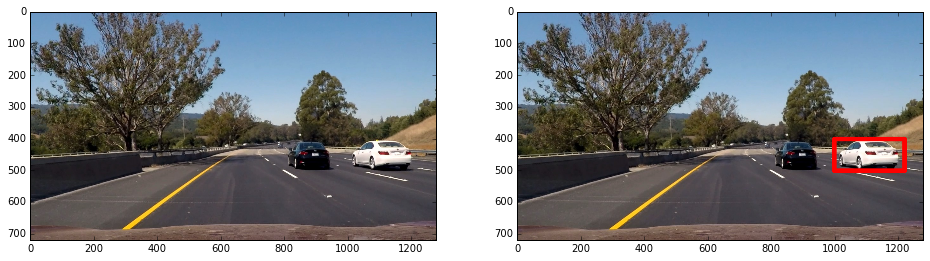

In [19]:

imagePath = './test_images/test6.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))


batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
start_time = time.time()
out = model.predict(batch)

boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.3)
end_time = time.time()
print('Image %s processed in %fs' % (imagePath, end_time - start_time))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))


Images in the net processed in 0.130913s
Image 0 processed in 0.030771s
Image 1 processed in 0.030468s
Image 2 processed in 0.030869s
Image 3 processed in 0.030512s
Image 4 processed in 0.029993s
Image 5 processed in 0.029897s


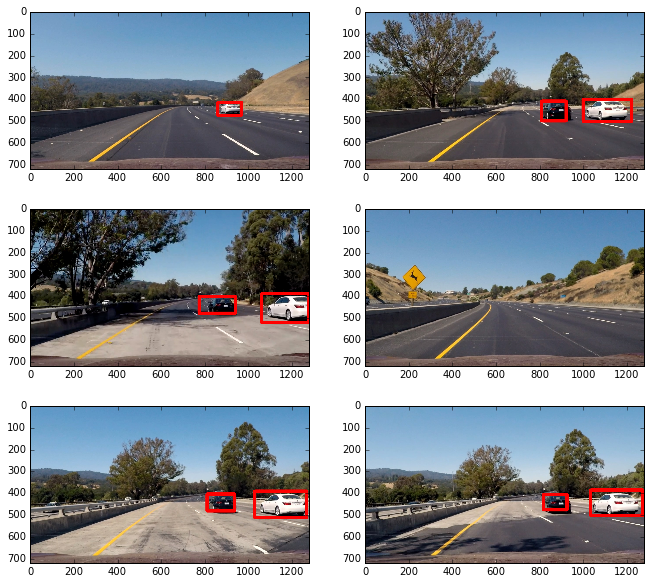

In [17]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
start_time = time.time()
out = model.predict(batch)
end_time = time.time()
print('Images in the net processed in %fs' % ( end_time - start_time))
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))

for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    start_time = time.time()
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))
    end_time = time.time()
    print('Image %d processed in %fs' % (i, end_time - start_time))

In [13]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [14]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [15]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [01:08<00:00, 18.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 31.5 s, sys: 4.99 s, total: 36.5 s
Wall time: 1min 10s


In [14]:
project_video_output = './psolidYellowLeft_output.mp4'
clip1 = VideoFileClip("./solidYellowLeft.mp4")
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)